In [1]:
import fastai
from fastai.vision import *
import pretrainedmodels

In [2]:
path = Path('.')

In [3]:
train = path/'train_dehaze/'
test =  path/'leaderboard_test_data_dehaze/'
holdout = path/'leaderboard_holdout_data_dehaze/'
sample_sub = path/'SampleSubmission.csv'
labels = path/'traininglabels.csv'

In [4]:
test_names = [f for f in test.iterdir()]
holdout_names = [f for f in holdout.iterdir()]

In [5]:
df = pd.read_csv(labels)
df_sample = pd.read_csv(sample_sub)

In [6]:
df.head()

,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


In [7]:
(df.has_oilpalm==1).sum()

942

In [195]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        input = input[:,1]
        target = target.float()
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

In [196]:
def get_data(size=128, bs=64, pct=0.2, seed=2019, n_sample=len(df)):
    src = (ImageItemList.from_df(df.sample(n_sample), path, folder=train)
           .random_split_by_pct(pct, seed=seed)
           .label_from_df('has_oilpalm')
           .add_test(test_names+holdout_names))
    return (src.transform(get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.), size=size)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

In [219]:
#This was working perfectly some minutes ago!
from sklearn.metrics import roc_auc_score
def auc_score(y_score,y_true):
    return torch.tensor(roc_auc_score(y_true,y_score[:,1])) # use as metric

def get_learner(data, mixup=True, fp16=True):
    learn = create_cnn(data, 
                       models.resnet18,
                       pretrained=True,
#                        loss_func=FocalLoss(),
                       metrics=[accuracy])
    if mixup: learn.mixup()
    if fp16: return learn.to_fp16()
    else: return learn

In [220]:
data = get_data(256, 64)

In [221]:
learn = get_learner(data)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02


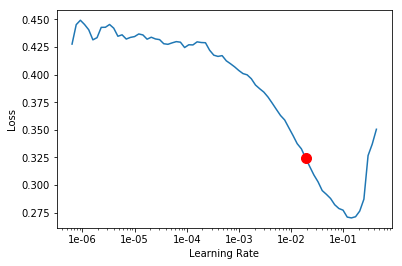

In [204]:
learn.lr_find(); learn.recorder.plot()

In [206]:
lr = 2e-2

256

In [207]:
learn.fit_one_cycle(12, lr)
learn.save('256')

epoch,train_loss,valid_loss,accuracy
1,0.054623,0.016135,0.943241
2,0.040777,0.041817,0.880906
3,0.038028,0.014093,0.987533
4,0.036498,0.038636,0.946522
5,0.033852,0.023228,0.981299
6,0.033005,0.015291,0.982612
7,0.032149,0.015376,0.990814
8,0.031278,0.008190,0.992782
9,0.028751,0.015076,0.987533
10,0.027265,0.009997,0.992782


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06


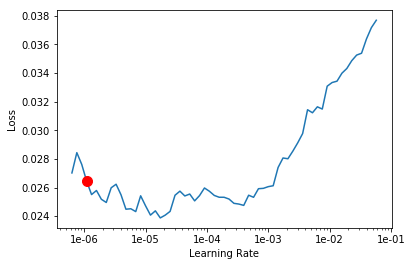

In [208]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [209]:
learn.fit_one_cycle(12, slice(1e-6,1e-4))
learn.save('256u')

epoch,train_loss,valid_loss,accuracy
1,0.026728,0.009313,0.992782
2,0.025883,0.009554,0.993438
3,0.024580,0.009239,0.993766
4,0.023506,0.009196,0.992782
5,0.025246,0.009135,0.992782
6,0.025538,0.008618,0.993438
7,0.025532,0.009088,0.992782
8,0.024564,0.009339,0.993438
9,0.025041,0.009309,0.993438
10,0.024662,0.008962,0.992782


In [200]:
learn.load('256u');

In [201]:
learn.fit_one_cycle(12, slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.025796,0.007195,0.990157
2,0.026994,0.007530,0.989829
3,0.027375,0.008743,0.989501
4,0.024906,0.009595,0.990486
5,0.024105,0.009907,0.990157


KeyboardInterrupt: 

> /opt/conda/lib/python3.7/site-packages/torch/tensor.py(363)__rsub__()
    361 
    362     def __rsub__(self, other):
--> 363         return _C._VariableFunctions.rsub(self, other)
    364 
    365     def __rdiv__(self, other):

ipdb>  q


In [191]:
%pdb

Automatic pdb calling has been turned ON


Results

In [223]:
learn = get_learner(data, mixup=False)
learn.load('256u')
interp = ClassificationInterpretation.from_learner(learn)

In [229]:
interp.top_losses(27)

(tensor([1.5005, 1.3282, 1.3157, 1.2734, 1.1297, 1.0958, 1.0913, 0.9631, 0.9625,
         0.9440, 0.9331, 0.9237, 0.9220, 0.8549, 0.8507, 0.8450, 0.8366, 0.8041,
         0.7998, 0.7887, 0.7869, 0.7619, 0.7550, 0.7316, 0.7148, 0.6984, 0.6953]),
 tensor([2668, 1562, 2317, 2490, 1911, 1337, 2970, 2936, 2477, 2625, 2645,  396,
         2866,  243, 2649,  591,  934,  729,  910, 2329, 1970, 1395, 2859, 2672,
         2248,  285,  341]))

[(1, 0, 24), (0, 1, 3)]

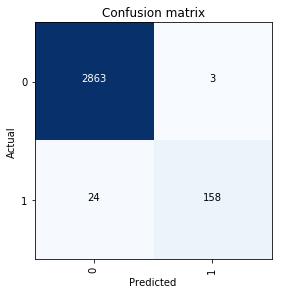

In [225]:
interp.plot_confusion_matrix()
interp.most_confused()

In [226]:
def top_losses(k, ds_type=DatasetType.Valid):
    p,t = learn.get_preds(ds_type)
    probs = p[:,1].sigmoid()
    errors = (t.float() - probs)**2
    e, idxs = errors.topk(k)
    return probs[idxs],t[idxs], e, idxs

In [230]:
probs, y, errors, idxs = top_losses(24)

In [231]:
idxs

tensor([ 396, 2329, 2672,  318, 2085, 1634, 1513, 2961, 1507, 2151, 1728,   22,
         123, 2736, 2885,   33, 2260, 1918, 2419, 2590, 1520,  485, 1594, 1160])

In [67]:
hard_images = data.train_ds.items[idxs]

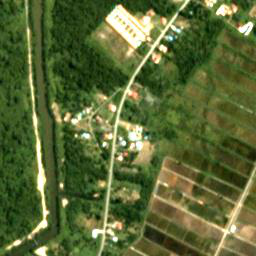

In [73]:
open_image(hard_images[0])

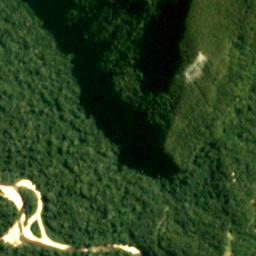

In [75]:
open_image(hard_images[2])

In [59]:
hard_images_names = [f[-17:] for f in hard_images]; hard_images_names[0:3]

['img_068602017.jpg', 'img_096672017.jpg', 'img_085452017.jpg']

In [78]:
df.head()

,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


In [79]:
df2 = df.set_index('image_id')

In [80]:
df2.loc[hard_images_names]

,has_oilpalm,score
image_id,,
img_068602017.jpg,1,1.0000
img_096672017.jpg,0,0.8186
img_085452017.jpg,0,1.0000
img_030232017.jpg,0,1.0000
img_059512018.jpg,0,1.0000
img_042832017.jpg,0,1.0000
img_032342018.jpg,0,1.0000
img_080842018.jpg,0,1.0000
img_096812017.jpg,0,1.0000


## Sub file

In [16]:
ids = np.array([f.name for f in test_names]+[f.name for f in holdout_names])

In [17]:
ids.shape

(6534,)

In [18]:
sub = pd.DataFrame(np.stack([ids, preds], axis=1), columns=df_sample.columns)

In [19]:
sub.to_csv('sub_resneXt101x5_haze_TTA.csv', index=False)

In [24]:
sub.has_oilpalm.asdtype(float)

AttributeError: 'Series' object has no attribute 'asdtype'